<a href="https://colab.research.google.com/github/paengeli/object_tracking/blob/master/headless_counting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from datetime import datetime
from collections import OrderedDict
from collections import Counter
from tqdm import tqdm
import numpy as np
import sqlite3
import cv2

DB_PATH = '/content/drive/MyDrive/Bees/data/bees.db'
ALT_PATH_TO_VIDEO = '/content/gdrive/My Drive/Bees/data/high_fps/' \
                    '118_Doettingen_Hive1_200820_gopro8_1080_100fps_W_short.mp4'
PATH_TO_VIDEO = '/content/drive/MyDrive/Bees/data/high_fps/118_Doettingen_Hive1_200820_gopro8_1080_200fps_W_short.mp4'
RUN_ID = 28
PLOT = True

In [3]:
# import the necessary packages
from scipy.spatial import distance as dist
#from kalmanFilter import KalmanFilter
from collections import OrderedDict
import numpy as np
from collections import deque
from scipy.optimize import linear_sum_assignment

np.set_printoptions(linewidth=220)

class Tracks(object):
    def __init__(self, detection, trackId):
        super(Tracks, self).__init__()
        # self.KF = KalmanFilter()
        # self.KF.predict()
        # self.KF.correct(np.matrix(detection).reshape(2, 1))
        self.trace = deque(maxlen=50)
        self.prediction = detection.reshape(1, 2)
        self.trackId = trackId
        self.skipped_frames = 0

    # def predict(self, detection):
    #     self.prediction = np.array(self.KF.predict()).reshape(1, 2)
    #     self.KF.correct(np.matrix(detection).reshape(2, 1))



class Tracker():
    def __init__(self, dist_threshold, max_frame_skipped, max_trace_length, iou_threshold):
        super(Tracker, self).__init__()
        self.dist_threshold = dist_threshold
        self.max_frame_skipped = max_frame_skipped
        self.trace = deque(maxlen=max_trace_length)
        self.max_trace_length = max_trace_length
        self.iou_threshold = iou_threshold
        self.trackId = 0
        self.tracks = []
        self.nextObjectID = 0
        self.objects = OrderedDict()
        self.objects_trace = OrderedDict()
        self.disappeared = OrderedDict()
        self.mixed_up = OrderedDict()
        self.max_leave_out = 2
        self.maxDisappeared = max_frame_skipped

    def get_iou_score(self, box1: np.ndarray, box2: np.ndarray):
        """
        calculate intersection over union cover percent
        :param box1: box1 with shape (N,4) or (N,2,2) or (2,2) or (4,). first shape is preferred
        :param box2: box2 with shape (N,4) or (N,2,2) or (2,2) or (4,). first shape is preferred
        :return: IoU ratio if intersect, else 0
        """
        # first unify all boxes to shape (N,4)
        if box1.shape[-1] == 2 or len(box1.shape) == 1:
            box1 = box1.reshape(1, 4) if len(box1.shape) <= 2 else box1.reshape(box1.shape[0], 4)
        if box2.shape[-1] == 2 or len(box2.shape) == 1:
            box2 = box2.reshape(1, 4) if len(box2.shape) <= 2 else box2.reshape(box2.shape[0], 4)
        point_num = max(box1.shape[0], box2.shape[0])
        b1p1, b1p2, b2p1, b2p2 = box1[:, :2], box1[:, 2:], box2[:, :2], box2[:, 2:]

        # mask that eliminates non-intersecting matrices
        base_mat = np.ones(shape=(point_num,))
        base_mat *= np.all(np.greater(b1p2 - b2p1, 0), axis=1)
        base_mat *= np.all(np.greater(b2p2 - b1p1, 0), axis=1)

        # I area
        intersect_area = np.prod(np.minimum(b2p2, b1p2) - np.maximum(b1p1, b2p1), axis=1)
        # U area
        union_area = np.prod(b1p2 - b1p1, axis=1) + np.prod(b2p2 - b2p1, axis=1) - intersect_area
        # IoU
        if union_area.all():
            intersect_ratio = intersect_area / union_area
        else:
            intersect_ratio = 0

        return base_mat * intersect_ratio

    def register(self, coordinates):
        # coordinates in the format [xmin,ymin,xmax,ymax]
        self.objects[self.nextObjectID] = coordinates
        self.objects_trace[self.nextObjectID] = [self.get_centroid(coordinates)]
        self.disappeared[self.nextObjectID] = 0
        self.mixed_up[self.nextObjectID] = 0
        self.nextObjectID += 1


    def deregister(self, objectID):
        del self.objects[objectID]
        del self.objects_trace[objectID]
        del self.disappeared[objectID]
        del self.mixed_up[objectID]

    def get_centroid(self, coordinates):
        return (coordinates[0] + (coordinates[2] - coordinates[0]) // 2,
                coordinates[1] + (coordinates[3] - coordinates[1]) // 2)

    def get_min_distance_order(self, D):
        D_order = []
        for i in range(D.shape[1]):
            sorted_col = np.argsort(D[:, i])
            for j in range(D.shape[0]):
                if sorted_col[j] not in D_order:
                    D_order.append(sorted_col[j])
                    break
        return D_order

    def get_max_iou_order(self, iou_scores):
        I = np.absolute(np.array(iou_scores))
        I_order = []
        for i in range(I.shape[1]):
            sorted_col = np.argsort(-I[:, i])
            for j in range(I.shape[0]):
                if sorted_col[j] not in I_order:
                    I_order.append(sorted_col[j])
                    break
        return I_order

    def update(self, rects):
        detections = []
        inputCoordinates = np.array(rects)
        if len(self.tracks) == 0:
            for i in range(np.array(rects).shape[0]):
                centroid = self.get_centroid(rects[i])
                track = Tracks(np.array(list(centroid)), self.trackId)
                detections.append(list(centroid))
                self.register(inputCoordinates[i])
                self.trackId += 1
                self.tracks.append(track)
                D=[]
                iou_scores = []

        else:
            objectCoordinates = list(self.objects.values())
            if len(inputCoordinates) > len(objectCoordinates):
                d_row, d_col = linear_sum_assignment(dist.cdist(np.array(objectCoordinates), inputCoordinates,'euclidean'))
                for i,k in enumerate(inputCoordinates):
                    if i not in d_col:
                        self.register(inputCoordinates[i])

            objectIDs = list(self.objects.keys())
            objectCoordinates = list(self.objects.values())
            D = dist.cdist(np.array(objectCoordinates), inputCoordinates,'euclidean')
            iou_scores = []
            for o in objectCoordinates:
                iou_scores.append(self.get_iou_score(np.array(o), np.array(inputCoordinates)))
            iou_scores = np.array(iou_scores)

            # order the distance matrix along the main diagonal with smallest values
            D_order = self.get_min_distance_order(np.array(D))

            # order the IOU matrix along the main diagonal with largest values
            I_order = self.get_max_iou_order(iou_scores)

            # merge both orderings and see which makes more sense
            order = []
            for i in range(len(D_order)):
                if D_order[i] == I_order[i]:
                    order.append(D_order[i])
                else:
                    if np.max(iou_scores[I_order,:][i]) == 0:
                        order.append(D_order[i])
                    else:
                        order.append(I_order[i])

            # check if new object came in between used cols
            # if iou_scores.shape[0] < iou_scores.shape[1]:
                # find new one and register it first and rerun order


            usedRows = set()
            usedCols = set()

            for col, row in enumerate(order):
                if row in usedRows or col in usedCols:
                    continue

                if iou_scores[row, col] >= self.iou_threshold or D[row, col] <= self.dist_threshold:
                    objectID = objectIDs[row]
                    self.objects[objectID] = inputCoordinates[col]
                    self.objects_trace[objectID].append(self.get_centroid(inputCoordinates[col]))
                    self.disappeared[objectID] = 0
                    usedRows.add(row)
                    usedCols.add(col)

                else:
                    pass

            unusedRows = set(range(0, iou_scores.shape[0])).difference(usedRows)
            unusedCols = set(range(0, iou_scores.shape[1])).difference(usedCols)


            if iou_scores.shape[0] >= iou_scores.shape[1]:
                for row in unusedRows:
                    objectID = objectIDs[row]
                    self.disappeared[objectID] += 1
                    if self.disappeared[objectID] > self.maxDisappeared:
                        self.deregister(objectID)
            else:
                for col in unusedCols:
                    self.register(inputCoordinates[col])

        
        return self.objects, self.objects_trace


In [4]:
conn = sqlite3.connect(DB_PATH)
c = conn.cursor()

In [5]:
def get_coordinates_from_db(run_id, video, frame_nr):
    c.execute(
        "select * from coordinates where run_id = {} and video = '{}' and frame = {}".format(run_id, video, frame_nr))
    return c.fetchall()

In [6]:
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

dateTimeObj = datetime.now()
time_stamp = dateTimeObj.strftime("%d_%b_%Y_%H_%M_%S.%f")

c.execute("select max(frame) from coordinates where run_id = {}".format(RUN_ID))
max_frame = c.fetchall()[0][0]

100%|██████████| 12001/12001 [10:10<00:00, 19.66it/s]


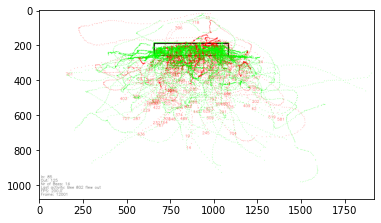

  0%|          | 0/6001 [00:00<?, ?it/s]

[('Frame', 12001), ('FPS', 200.0), ('Last activity', 'Bee 802 flew out'), ('Nr of Bees', 14), ('Out', 125), ('In', 85)]


100%|██████████| 6001/6001 [04:42<00:00, 21.25it/s]


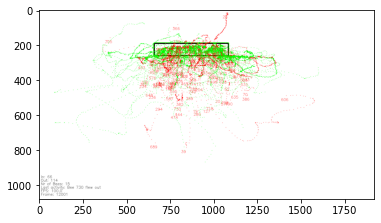

  0%|          | 0/3001 [00:00<?, ?it/s]

[('Frame', 12001), ('FPS', 100.0), ('Last activity', 'Bee 730 flew out'), ('Nr of Bees', 15), ('Out', 114), ('In', 66)]


100%|██████████| 3001/3001 [02:16<00:00, 22.02it/s]


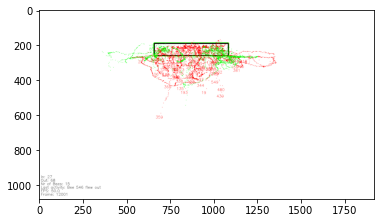

  0%|          | 0/1501 [00:00<?, ?it/s]

[('Frame', 12001), ('FPS', 50.0), ('Last activity', 'Bee 546 flew out'), ('Nr of Bees', 15), ('Out', 68), ('In', 27)]


100%|██████████| 1501/1501 [01:07<00:00, 22.13it/s]


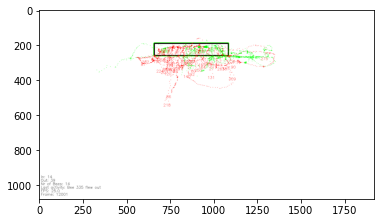

[('Frame', 12001), ('FPS', 25.0), ('Last activity', 'Bee 335 flew out'), ('Nr of Bees', 14), ('Out', 39), ('In', 14)]
[('Frame', 12001), ('FPS', 25.0), ('Last activity', 'Bee 335 flew out'), ('Nr of Bees', 14), ('Out', 39), ('In', 14)]


In [7]:
for skip_param in [1,2,4,8]:
  cap = cv2.VideoCapture(PATH_TO_VIDEO)
  fps = int(cap.get(cv2.CAP_PROP_FPS))
  ct = Tracker(50, 25, 50, 0.25)
  fps = fps / skip_param

  detections = []


  blank_image = np.zeros((height, width, 3), np.uint8)
  blank_image[:, :] = (255, 255, 255)

  img_center_x = width // 2 - 55
  img_center_y = height // 2 - 20
  # for united queens circle!
  # cv2.circle(blank_image, (img_center_x, img_center_y), 135, (0, 0, 0), 5)
  cv2.rectangle(blank_image, (660, 190), (1085, 260), (0, 0, 0),
              5)  # first tuple is the start, second tuple the end coordinates

  gray = cv2.cvtColor(blank_image, cv2.COLOR_BGR2GRAY)
  gray = cv2.bilateralFilter(gray, 11, 17, 17)
  edged = cv2.Canny(gray, 200, 800, 1)
  contours = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  contours = contours[0] if len(contours) == 2 else contours[1]

  traffic_dict = OrderedDict()
  bee_in = 0
  bee_out = 0
  activity = ""

  frame = 0
  frame_counter = 0
  all_tracks = {}
  in_counted = []
  out_counted = []

  for frame in tqdm(range(1, max_frame, skip_param)):
      coordinates = get_coordinates_from_db(RUN_ID, ALT_PATH_TO_VIDEO, frame)

      rects = []
      for i in range(len(coordinates)):
          r_id, f_name, fr, b_id, xmin, xmax, ymin, ymax, X, Y, conf = coordinates[i]
          rects.append([xmin, ymin, xmax, ymax])

      objects, tracks = ct.update(rects)

      if PLOT:
          for key, values in tracks.items():
              if key not in all_tracks:
                  all_tracks[key] = values
              else:
                  all_tracks[key].append(values[-1])

      for (objectID, coordinates) in objects.items():
          if len(traffic_dict) == 0:
              traffic_dict[objectID] = []

          for cnt in contours:
              centroid_x = coordinates[0] + (coordinates[2] - coordinates[0]) // 2
              centroid_y = coordinates[1] + (coordinates[3] - coordinates[1]) // 2
              centroid = (centroid_x, centroid_y)
              res = cv2.pointPolygonTest(cnt, (centroid_x, centroid_y), False)
              traffic_dict[objectID].append(res)

              IN = False
              if res == 1 or res == 0:
                  IN = True

          try:
              len(traffic_dict[objectID + 1])
          except KeyError:
              traffic_dict[objectID + 1] = []

      if len(traffic_dict) > 0:
          for tb_id, tb_value in traffic_dict.items():
              if len(tb_value) == 0:
                  continue
              if tb_id not in objects:
                  last_counter = Counter(tb_value[-20:])
                  total_counter = Counter(tb_value)
                  if tb_value[0] == -1 and total_counter[-1] >= fps // 20 and last_counter[1] >= fps // 20:
                      bee_in += 1
                      traffic_dict[tb_id] = []
                      activity = "Bee {} flew in".format(tb_id)
                      in_counted.append(tb_id)
                  if tb_value[0] == 1 and total_counter[1] >= fps // 20 and last_counter[-1] >= fps // 20:
                      bee_out += 1
                      traffic_dict[tb_id] = []
                      activity = "Bee {} flew out".format(tb_id)
                      out_counted.append(tb_id)

      info = [("Frame", frame), ("FPS", fps), ("Last activity", activity), ("Nr of Bees", int(len(objects))),
              ("Out", bee_out),
              ("In", bee_in)]

      """if frame % 1000 == 0:
          break
          print(info)
          print(traffic_dict)"""


  if PLOT:
      for cnt in contours:
          cv2.drawContours(blank_image, [cnt], -1, (36, 255, 12), 2)


      disappeared = out_counted + in_counted
      for id in disappeared:
          if id in all_tracks.keys():
              for point in all_tracks[id]:
                  if id in out_counted:
                      color = (255,0,0)
                  elif id in in_counted:
                      color = (0,255,0)
                  cv2.circle(blank_image, (point[0], point[1]), 1, color, -1)
              cv2.putText(blank_image, str(id), (point[0] - 30, point[1] + 30), 0, 0.7,
                              color, 1)
              for (i, (k, v)) in enumerate(info):
                  text = "{}: {}".format(k, v)
                  cv2.putText(blank_image, text, (10, int(height) - ((i * 20) + 20)), cv2.FONT_HERSHEY_SIMPLEX, 0.7,
                              (0, 0, 0),
                              1)


      import matplotlib.pyplot as plt
      fig1 = plt.figure()
      plt.imshow(blank_image)
      plt.show()
      fig1.savefig(str(fps)+'.png', dpi = 1000)
      print(info)

print(info)
conn.close()